<h1>Discovering InterConnect Churn</h1>
<h2>Imports and Dependancies</h2>

In [3]:
import sys
import subprocess

def install(package_name, import_name=None):
    import_name = import_name or package_name
    try:
        __import__(import_name)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])

install("pandas")
install("numpy")
install("matplotlib")
install("seaborn")
install("scikit-learn", "sklearn")
install("xgboost")
install('shap')

In [4]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV

contract_df = pd.read_csv('datasets/contract.csv')
internet_df = pd.read_csv('datasets/internet.csv')
customer_info = pd.read_csv('datasets/personal.csv')
phone_df = pd.read_csv('datasets/phone.csv')

state=54321
n_jobs=2

<h1>Project Plan</h1>
<h2>Project Work Plan / Processing and Exploring Data</h2>
<h3>Contract Information Database</h3>

In [5]:
display(contract_df.head(10))
display(f"DataFrame shape: {contract_df.shape}")
missing_info = contract_df.isna().sum()
missing_info = missing_info[missing_info > 0].sort_values(ascending=False)
display(missing_info)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


'DataFrame shape: (7043, 8)'

Series([], dtype: int64)

<h3>Internet Information Database</h3>

In [6]:
display(internet_df.head(10))
display(f"DataFrame shape: {internet_df.shape}")
missing_info = internet_df.isna().sum()
missing_info = missing_info[missing_info > 0].sort_values(ascending=False)
display(missing_info)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


'DataFrame shape: (5517, 8)'

Series([], dtype: int64)

<h3>Phone Information Database</h3>

In [7]:
display(phone_df.head(10))
display(f"DataFrame shape: {phone_df.shape}")
missing_info = phone_df.isna().sum()
missing_info = missing_info[missing_info > 0].sort_values(ascending=False)
display(missing_info)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


'DataFrame shape: (6361, 2)'

Series([], dtype: int64)

<h3>Customer Information Database</h3>

In [8]:
display(customer_info.head(10))
display(f"DataFrame shape: {customer_info.shape}")
missing_info = customer_info.isna().sum()
missing_info = missing_info[missing_info > 0].sort_values(ascending=False)
display(missing_info)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


'DataFrame shape: (7043, 5)'

Series([], dtype: int64)

<h3>Initial Observations</h3>
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The order of customers within each database appears consistent, with individuals who do not have phone plans excluded from the phone database entirely. The number of customers we have personal info on and the number of contracts we have is consistent as well. A curious observation is that customer 6388-TABGU appears in both the phone and internet databases but is marked "No" for the multiline question in the phone database. This suggests that "multiple lines" refers to individual phone lines rather than multiple services from InterConnect. Several features across the datasets appear pertinent to churn prediction, particularly those related to product usage and client trust.</p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Notably, all datasets are free of missing values, simplifying the data preprocessing stage and allowing for a more efficient modeling pipeline. The phone database can likely be merged into the internet database as an addendum to create a unified Product database. Similarly, the contract and personal information databases can be combined with relative ease. These integrations will help reduce data loading time during model training and development. I will clean and normalize the data from these dataframes before combining them into a unified, clean dataset.</p> 
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I plan to implement an initial model using a diverse 20%–40% sample of the data to identify potential noise that may affect full-model accuracy and to explore feature weighting. With data quality confirmed, I will proceed with preliminary modeling. Finally, I will develop a classifier to identify active users who are "at risk" of leaving. I will also explore expanding churn risk classification into tiers—such as "no risk," "possible risk," "at risk," and "very high risk"—enabling the marketing team to tailor engagement strategies to each group.</p>

<h2>Preprocessing Databases</h2>

In [9]:
customer_info = customer_info.drop_duplicates(subset='customerID').reset_index(drop=True)
phone_df = phone_df.drop_duplicates(subset='customerID').reset_index(drop=True)
internet_df = internet_df.drop_duplicates(subset='customerID').reset_index(drop=True)
contract_df = contract_df.drop_duplicates(subset='customerID').reset_index(drop=True)

product_df = pd.merge(internet_df, phone_df, on='customerID', how='outer')
product_df['MultipleLines'] = product_df['MultipleLines'].fillna(np.nan)

client_df = pd.merge(contract_df, customer_info, on='customerID', how='inner')
client_df = client_df.sort_values(by='customerID', ascending=True).reset_index(drop=True)
full_df = pd.merge(client_df, product_df, on='customerID', how='inner')
full_df = full_df.drop_duplicates(subset='customerID').reset_index(drop=True)

display(product_df.head())
display(client_df.head())
display(full_df.head())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,0002-ORFBO,DSL,No,Yes,No,Yes,Yes,No,No
1,0003-MKNFE,DSL,No,No,No,No,No,Yes,Yes
2,0004-TLHLJ,Fiber optic,No,No,Yes,No,No,No,No
3,0011-IGKFF,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
4,0013-EXCHZ,Fiber optic,No,No,No,Yes,Yes,No,No


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,593.3,Female,0,Yes,Yes
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,542.4,Male,0,No,No
2,0004-TLHLJ,2019-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.9,280.85,Male,0,No,No
3,0011-IGKFF,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,98.0,1237.85,Male,1,Yes,No
4,0013-EXCHZ,2019-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,83.9,267.4,Female,1,Yes,No


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,593.3,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,542.4,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes
2,0004-TLHLJ,2019-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.9,280.85,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No
3,0011-IGKFF,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,98.0,1237.85,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
4,0013-EXCHZ,2019-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,83.9,267.4,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No


In [10]:
full_df['TotalCharges'] = pd.to_numeric(full_df['TotalCharges'], errors='coerce')
full_df['BeginDate'] = pd.to_datetime(full_df['BeginDate'])
full_df['EndDate'] = pd.to_datetime(full_df['EndDate'], errors='coerce')

today = pd.to_datetime('03-01-2020')

full_df['BeginYear'] = full_df['BeginDate'].dt.year
full_df['BeginMonth'] = full_df['BeginDate'].dt.month
    
features_raw = full_df.drop(['customerID', 'EndDate', 'BeginDate'], axis=1)
full_df['is_active'] = full_df['EndDate'].isna()
target = full_df['is_active']

print(f"!!! ------ Column unique values ------ !!!\n")
for column in features_raw.columns:
    if column in ['BeginYear', 'BeginMonth', 'MonthlyCharges', 'TotalCharges']:
        continue
    print(f"\tColumn: {column}")
    print("\t\t", features_raw[column].unique())
    print("-" * 40)

convert = []

for column in features_raw.columns:
    if features_raw[column].dtype == 'object':
        convert.append(column)

features = pd.get_dummies(features_raw, columns=convert, drop_first=True)
display(features.head())

print(target.value_counts(normalize=True))

!!! ------ Column unique values ------ !!!

	Column: Type
		 ['One year' 'Month-to-month' 'Two year']
----------------------------------------
	Column: PaperlessBilling
		 ['Yes' 'No']
----------------------------------------
	Column: PaymentMethod
		 ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']
----------------------------------------
	Column: gender
		 ['Female' 'Male']
----------------------------------------
	Column: SeniorCitizen
		 [0 1]
----------------------------------------
	Column: Partner
		 ['Yes' 'No']
----------------------------------------
	Column: Dependents
		 ['Yes' 'No']
----------------------------------------
	Column: InternetService
		 ['DSL' 'Fiber optic' nan]
----------------------------------------
	Column: OnlineSecurity
		 ['No' 'Yes' nan]
----------------------------------------
	Column: OnlineBackup
		 ['Yes' 'No' nan]
----------------------------------------
	Column: DeviceProtection
		 ['No' 'Yes' nan]
-----

/tmp/ipykernel_29364/3923174361.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  full_df['EndDate'] = pd.to_datetime(full_df['EndDate'], errors='coerce')


,MonthlyCharges,TotalCharges,SeniorCitizen,BeginYear,BeginMonth,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
0,65.6,593.30,0,2019,5,True,False,True,False,False,...,True,True,False,False,True,False,True,True,False,False
1,59.9,542.40,0,2019,5,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
2,73.9,280.85,0,2019,9,False,False,True,False,True,...,False,False,True,False,False,True,False,False,False,False
3,98.0,1237.85,1,2018,12,False,False,True,False,True,...,True,False,True,False,True,True,False,True,True,False
4,83.9,267.40,1,2019,9,False,False,True,False,False,...,True,False,True,False,False,False,True,True,False,False


is_active
True     0.73463
False    0.26537
Name: proportion, dtype: float64


<h4>Graphing the Data</h4>

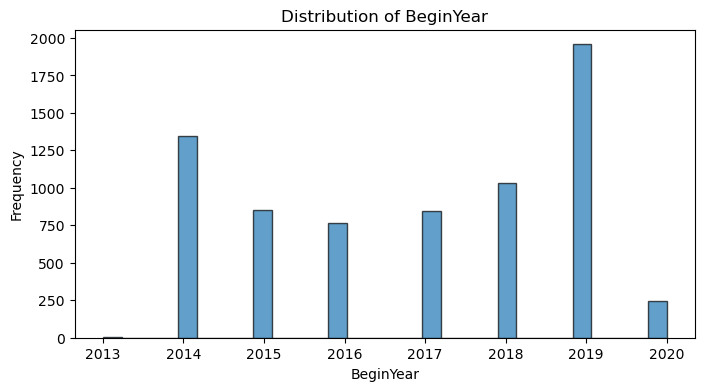

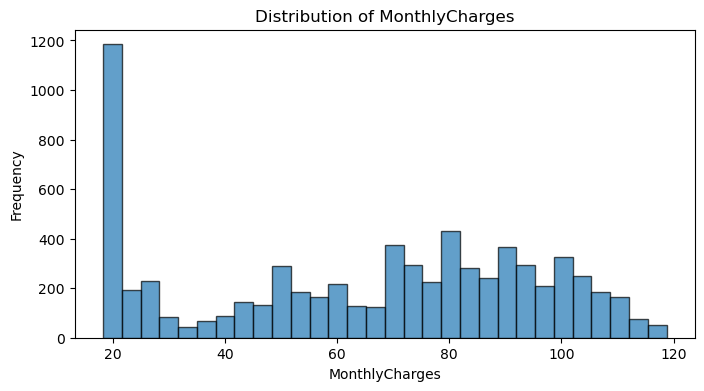

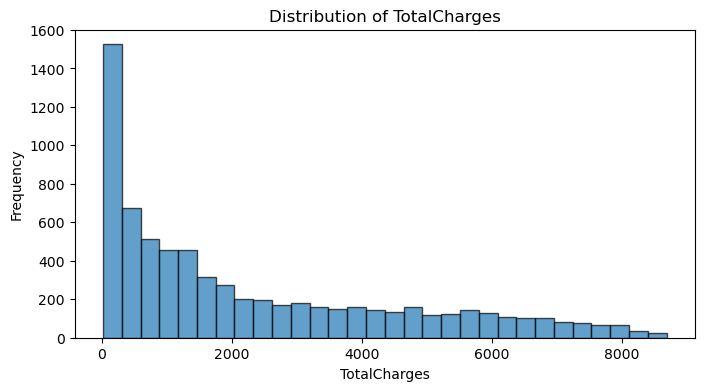

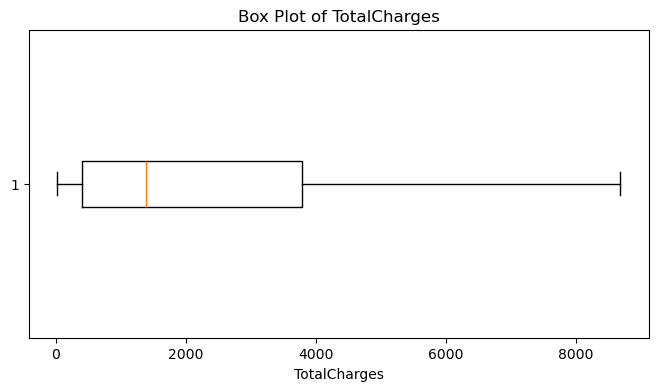

In [11]:
for column in ['BeginYear', 'MonthlyCharges', 'TotalCharges']:
   plt.figure(figsize=(8, 4))
   plt.hist(full_df[column], bins=30, edgecolor='k', alpha=0.7)
   plt.title(f'Distribution of {column}')
   plt.xlabel(column)
   plt.ylabel('Frequency')
   plt.show()
    
for column in ['TotalCharges']:
    plt.figure(figsize=(8, 4))
    clean_data = pd.to_numeric(full_df[column], errors='coerce').dropna()
    plt.boxplot(clean_data, vert=False)
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.show()

<h4>Chart and Data Processing Observations</h4>
<p>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Several adjustments were made to better support the development of a functional model for predicting customer churn. One key observation was the box plot for <strong>TotalCharges</strong> revealed the presence of outliers and a right-skewed distribution. To address this, a logarithmic transformation will be applied to reduce skewness and improve the model’s performance and reliability. I also notice a good portion of clients began in 2019 while a substantial less where in 2020, suggesting that the year 2020 had just begun as of the recording of this data.
</p>


## Work Plan Questions and Continuance

### Clarifying Questions

1. **What is the correct record date for the data?**  
   I currently set it to March 31st, 2020 (last day of the quarter), based on the latest entry being January 1st, 2020. Knowing the true snapshot date would allow the model to correctly evaluate the recency of customer relationships.

2. **What is the exact nature of "Total Charges"?**  
   I assume it's the aggregate amount each client has paid. However, if it includes future charges or estimated values, it could introduce data leakage, especially if it correlates with churn before it happens.

---

### Work Plan (3–5 Steps)

1. **Transform Skewed Features**  
   Apply a logarithmic transformation to the `TotalCharges` feature to reduce skew and make the distribution more model-friendly while preserving its relationship to tenure and customer engagement.

2. **Split the Dataset**  
   Divide the data into training (~57%), validation (20%), and test (17.65%) sets to ensure robust evaluation and hyperparameter tuning.

3. **Train an XGBoost Classifier**  
   Use randomized search cross-validation to tune hyperparameters such as learning rate, max depth, and the number of estimators for the XGBoost model.

4. **Interpret Model Using SHAP**  
   Use SHAP (SHapley Additive exPlanations) values to assess the importance of each feature and understand the drivers of churn in a transparent and interpretable way.

5. **Classify Customers by Risk Level**  
   Based on model probabilities, classify clients into five churn risk levels to help guide business interventions and retention strategies.

---

### Conclusion

I will summarize the results, key drivers of churn, and offer data-driven recommendations for retention improvements such as customer loyalty programs.


<h3>Training Models</h3>
<h4>Log Transforming TotalCharge and Spliting Data</h4>

In [12]:
features['LogTotalCharges'] = np.log1p(features['TotalCharges'])
features = features.drop('TotalCharges', axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1765, stratify=target, random_state=state)

features_train, features_val, target_train, target_val = train_test_split(
    features_train, target_train, test_size=0.3, random_state=state)

<h4>Parameter Tuning and Training</h4>

In [13]:
params = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(random_state=state, eval_metric='logloss')
search = RandomizedSearchCV(xgb, params, n_iter=10, cv=5, scoring='roc_auc', random_state=state, n_jobs=-1)
search.fit(features_train, target_train)

print("Best params:", search.best_params_)
print("Best Training ROC_AUC_Score:", search.best_score_)

Best params: {'subsample': 1.0, 'n_estimators': 350, 'max_depth': 4, 'learning_rate': 0.4, 'colsample_bytree': 0.8}
Best Training ROC_AUC_Score: 0.9095258735980843


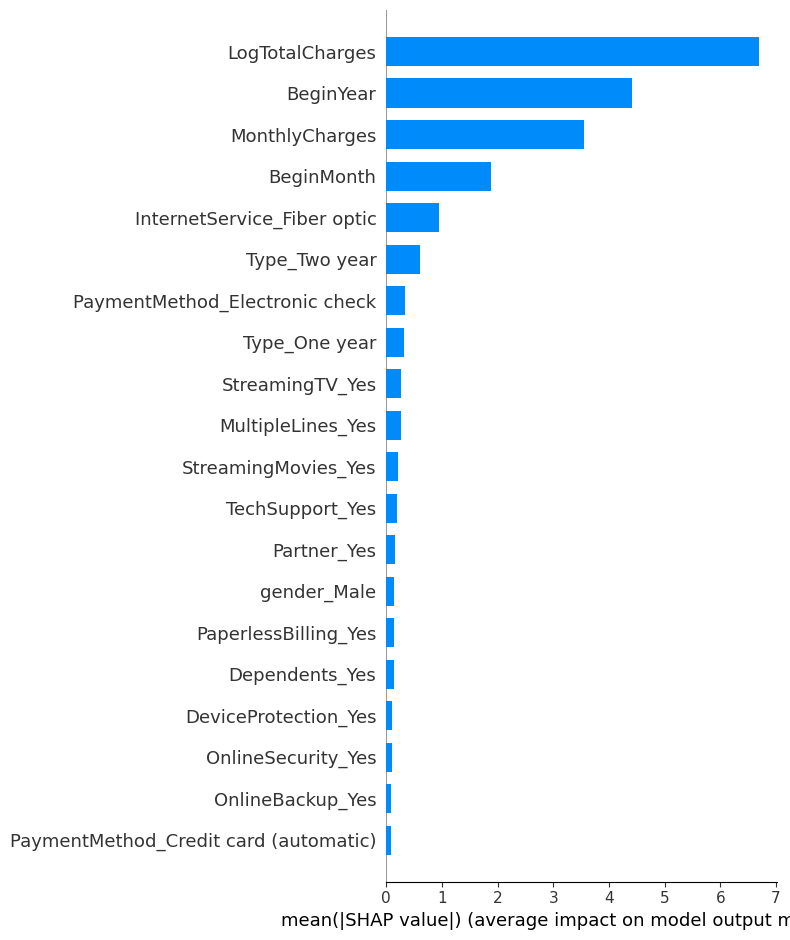

Test ROC_AUC_Score: 0.9222415622306213
Test Accuracy Score: 0.8890675241157556


In [14]:
xgb_best = search.best_estimator_

explainer = shap.Explainer(xgb_best)
shap_values = explainer(features)
shap.summary_plot(shap_values, features_test, plot_type="bar")

probs = xgb_best.predict_proba(features_test)[:, 1]
pred_test = xgb_best.predict(features_test)
test_auc = roc_auc_score(target_test, probs)
test_acc = accuracy_score(target_test, pred_test)
print("Test ROC_AUC_Score:", test_auc)
print("Test Accuracy Score:", test_acc)

In [15]:
probs = xgb_best.predict_proba(features_val)[:, 1]
pred_val = xgb_best.predict(features_val)
val_auc = roc_auc_score(target_val, probs)
val_acc = accuracy_score(target_val, pred_val)
print("Valid ROC_AUC_Score:", val_auc)
print("Valid Accuracy Score:", val_acc)

Valid ROC_AUC_Score: 0.9188027562446168
Valid Accuracy Score: 0.8862068965517241


<h2>Assigning Risk Catagories and displaying results</h2>
<h3>Function to Assign Categories</h3>

In [16]:
def assign_risk_category(probabilities):
    bins = [0, 0.5, 0.7, 0.8, 0.9, 1.0]
    labels = ['Very High Risk', 'High Risk', 'Moderate Risk', 'Small Risk', 'Very Small Risk']
    
    risk_categories = pd.cut(probabilities, bins=bins, labels=labels, right=False)
    
    return risk_categories

<h3>Assigning Categories to Entire List of Clients</h3>

In [17]:
probs = xgb_best.predict_proba(features)[:, 1]
full_df['Risk Level'] = pd.Series(assign_risk_category(probs), index=features.index)
display(full_df.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,BeginYear,BeginMonth,is_active,Risk Level
0,0002-ORFBO,2019-05-01,NaT,One year,Yes,Mailed check,65.6,593.30,Female,0,...,Yes,No,Yes,Yes,No,No,2019,5,True,Very Small Risk
1,0003-MKNFE,2019-05-01,NaT,Month-to-month,No,Mailed check,59.9,542.40,Male,0,...,No,No,No,No,Yes,Yes,2019,5,True,Very Small Risk
2,0004-TLHLJ,2019-09-01,2020-01-01,Month-to-month,Yes,Electronic check,73.9,280.85,Male,0,...,No,Yes,No,No,No,No,2019,9,False,Very High Risk
3,0011-IGKFF,2018-12-01,2020-01-01,Month-to-month,Yes,Electronic check,98.0,1237.85,Male,1,...,Yes,Yes,No,Yes,Yes,No,2018,12,False,Very High Risk
4,0013-EXCHZ,2019-09-01,2019-12-01,Month-to-month,Yes,Mailed check,83.9,267.40,Female,1,...,No,No,Yes,Yes,No,No,2019,9,False,Very High Risk


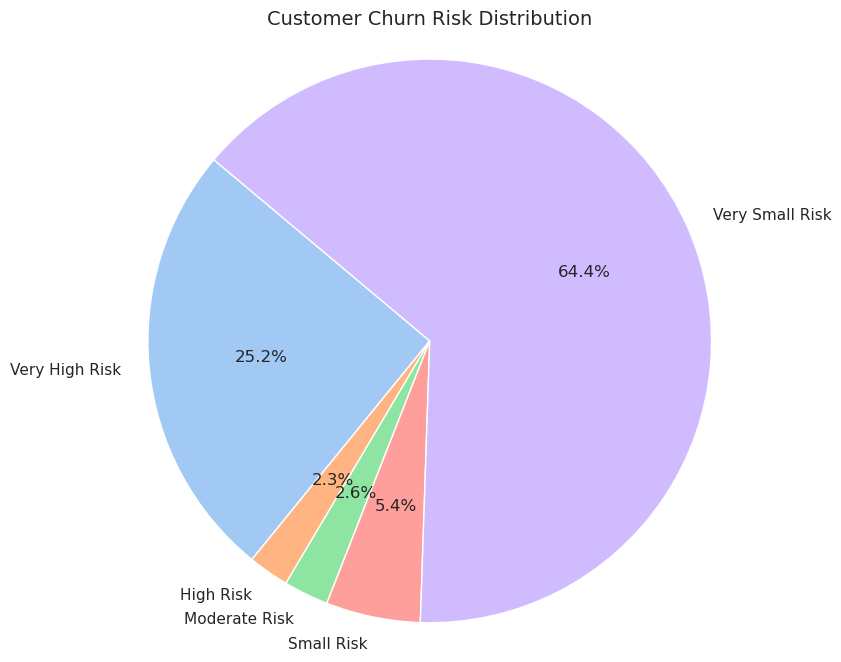

In [18]:
sns.set_theme(style="whitegrid")

risk_counts = full_df['Risk Level'].value_counts().sort_index()

plt.figure(figsize=(8, 8))
plt.pie(
    risk_counts, 
    labels=risk_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('pastel', n_colors=5)
)
plt.title("Customer Churn Risk Distribution", fontsize=14)
plt.axis('equal')
plt.show()

<h2>Conclusion</h2>
<p>&nbsp;&nbsp;&nbsp;&nbsp;Based on the provided charts and analysis, it is clear that Tenure is the most significant determinant of churn, with customers who have amassed higher total charges being less likely to churn. Clients paying by check, those with more agreeable monthly charges, seasonal "temporary" clients, customers using the more sophisticated and higher-performing fiber optic service, and those who participate in multiple programs all show a notable correlation with churn rates. Additionally, customers with one-year and two-year commitments are at a critical point where incentivizing loyalty could be key to reducing churn.</p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;As a potential action, implementing a "loyalty program" that offers reduced rates for fiber optic or any of our other premium services after reaching certain time-based milestones could help incentivize longer commitments and reduce churn. This approach would reward customers who stay longer, particularly those who are on the verge of churning. Further analysis could focus on segmenting customers by age, contract length, and usage to tailor retention efforts more effectively.</p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;While these findings provide a strong foundation for strategic decision-making, it’s important to consider limitations such as data availability and the potential for unobserved factors influencing churn. Future steps should include testing the effectiveness of the loyalty program through pilot testing or A/B testing to validate its impact on reducing churn. Additional features, such as customer satisfaction surveys or service support metrics, could provide further insight into the factors driving customer behavior.</p>